In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('../functions')

# Read Data

In [3]:
data = pandas.read_csv('Data/hits.csv', index_col=0)
data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,Time,ELoss,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,250.000000,0.868600,0.868600,2581.1500,2581.1500,2581.1500,0,383.880371,5.310523e-06,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,249.507863,27.037487,-16.540384,3542.3793,3542.3793,3542.3793,0,415.954742,5.271870e-07,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,249.509850,-27.060200,16.517671,2592.3793,2592.3793,2592.3793,0,384.254303,3.097434e-06,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,249.203062,-23.553595,20.024276,2592.3793,2592.3793,2592.3793,1,384.251007,3.362202e-06,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,250.000000,-0.011400,-0.011400,2782.2500,2782.2500,2782.2500,0,390.597870,1.754228e-06,0


# Tracks Reconstruction

In [4]:
from baseline import SimpleTemplateMatching
from hough import LinearHoughModel
from reconstruction import TracksReconstruction2D
from combination import Combinator
from retina import Retina2DTrackerOne


from metrics import TracksReconstractionMetrics, CombinatorQuality

### Tests

In [5]:
__author__ = 'mikhail91'

import numpy
import pandas
from sklearn.linear_model import LinearRegression

class ImprovedTemplateMatching(object):

    def __init__(self, n_max_hits, n_min_hits, window_width):
        """
        This class is simple realization of a Template Matching paradigm for straight tracks in 2D.
        :param n_max_hits: int, max min number of hits to consider the track recognized.
        :param n_min_hits: int, min min number of hits to consider the track recognized.
        :param window_width: float, width of a searching window for searching hits for a track.
        :return:
        """

        self.window_width = window_width
        self.n_max_hits = n_max_hits
        self.n_min_hits = n_min_hits

    def fit(self, x, y, sample_weight=None):
        """
        Fit the method.
        :param x: numpy.ndarray shape=[n_hits, n_features], X of hits.
        :param y: numpy.array shape=[n_hits], y of hits.
        :param sample_weight: numpy.array shape=[n_hits], weight of each hits.
        :return:
        """

        used = numpy.zeros(len(x))
        labels = -1. * numpy.ones(len(x))
        track_id = 0
        tracks_params = []

        for n_hits in range(self.n_min_hits, self.n_max_hits+1)[::-1]:

            for first_ind in range(len(x)):

                for second_ind in range(len(x)):

                    x1 = x[first_ind]
                    y1 = y[first_ind]

                    x2 = x[second_ind]
                    y2 = y[second_ind]

                    if (x1 >= x2) or (used[first_ind] == 1) or (used[second_ind] == 1):
                        continue

                    k = 1. * (y2 - y1) / (x2 - x1)
                    b = y1 - k * x1

                    y_upper = b + k * x.reshape(-1) + self.window_width
                    y_lower = b + k * x.reshape(-1) - self.window_width

                    track = (y <= y_upper) * (y >= y_lower) * (used == 0)
                    
                    track_x = x[track]
                    track_y = y[track]
                    track_index = numpy.arange(len(x))[track]
                    
                    dist = (track_y - track_x * k - b)**2
                    
                    unique_x = numpy.unique(track_x)
                    new_track_index = []
                    
                    for x_one in unique_x:
                        
                        ind_one = track_index[track_x == x_one]
                        dist_one = dist[track_x == x_one]
                        
                        new_ind_one = ind_one[dist_one == dist_one.min()][0]
                        
                        new_track_index.append(new_ind_one)
                        
                    new_track_index = numpy.array(new_track_index)
                    
                    track = numpy.in1d(range(len(x)), new_track_index)
                    

                    if track.sum() >= n_hits:

                        used[track] = 1
                        labels[track] = track_id
                        track_id += 1

                        x_track = x[track]
                        y_track = y[track]

                        if sample_weight != None:
                            sample_weight_track = sample_weight[track]
                        else:
                            sample_weight_track = None

                        lr = LinearRegression()
                        lr.fit(x_track.reshape(-1,1), y_track, sample_weight_track)

                        params = list(lr.coef_) + [lr.intercept_]
                        tracks_params.append(params)


        self.labels_ = labels
        self.tracks_params_ = numpy.array(tracks_params)


In [6]:
a = numpy.array([1,2,3,4])
b = numpy.array([1,3])

numpy.in1d(a, b)

array([ True, False,  True, False], dtype=bool)

In [7]:
event = data[data.EventID == 27]
event12 = event[(event.StatNb <= 2)*(event.ViewNb != 1)*(event.ViewNb != 2)]

x = event12.Wz1.values
y = event12.Wy1.values

In [8]:
%%time
rt = ImprovedTemplateMatching(n_max_hits=16, n_min_hits=7, window_width=0.75)

rt.fit(x, y)

labels = rt.labels_
tracks_params = rt.tracks_params_

CPU times: user 128 ms, sys: 5.54 ms, total: 133 ms
Wall time: 131 ms


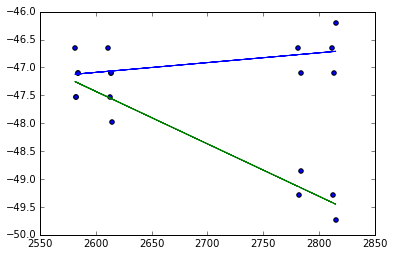

In [9]:
plt.scatter(x, y)
for n in range(len(tracks_params)):
    plt.plot(x, tracks_params[n][0] * x + tracks_params[n][1])
plt.show()

In [10]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency(eff_threshold=0.3)
hme.fit(event12.Label.values, labels)

hme.recognition_efficiency_

1.0

In [11]:
tracks_params

array([[  1.75307227e-03,  -5.16469971e+01],
       [ -9.40120214e-03,  -2.29876086e+01]])

In [12]:
labels

array([ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
        0.,  0.,  0.,  1.,  1.,  0.])

In [13]:
event12.Label.values

array([ 0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,
        0.,  0.,  0.,  1.,  1.,  0.])

### Tracks Reconstruction

In [14]:
%%time
from multiprocessing import Pool
from utils import merge_dicts

event_ids = numpy.unique(data.EventID.values)
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    # Select model for the tracks reconstruction
    stm_y = ImprovedTemplateMatching(n_max_hits=16, n_min_hits=5, window_width=0.7)
    stm_stereo = ImprovedTemplateMatching(n_max_hits=16, n_min_hits=5, window_width=15)
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    return one_track

if __name__ == "__main__":
    p = Pool(3)
    results = p.map(tracks_reconstruction, event_ids)
    tracks = merge_dicts(results)

CPU times: user 203 ms, sys: 59.7 ms, total: 262 ms
Wall time: 6min 11s


In [15]:
#tracks_reconstruction(2)

In [16]:
%%time

tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

for event_id in tracks.keys():
    
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    labels12 = tracks[event_id]['labels12']
    tracks_params12 = tracks[event_id]['params12']
    labels34 = tracks[event_id]['labels34']
    tracks_params34 = tracks[event_id]['params34']
    
    # Select model for the tracks reconstruction
    # stm_y = LinearHoughModel(k_params=(-0.2, 0.2, 0.0004), b_params=(-800, 800, 1.6), min_hits=4, multiplier=2)
    # stm_stereo = LinearHoughModel(k_params=(-0.2, 0.2, 0.005), b_params=(-800, 800, 10), min_hits=4, multiplier=2)
    
    
    # Tracks reconstruction before the magnet
    # tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d12.fit(event12, weights12)
    
    # labels12 = tr2d12.labels_
    # tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2)
    trm12.fit(labels12, event12)

    tracks_metrics_before_y.loc[len(tracks_metrics_before_y)] = [event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]

    tracks_metrics_before_stereo.loc[len(tracks_metrics_before_stereo)] = [event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    # tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d34.fit(event34, weights34)
    
    # labels34 = tr2d34.labels_
    # tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_y.loc[len(tracks_metrics_after_y)] = [event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]

    tracks_metrics_after_stereo.loc[len(tracks_metrics_after_stereo)] = [event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
        
    
    # Combination of the tracks before and after the magnet
    comb = Combinator(dy_max=2, dx_max=20)
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_true)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]

    
    
    # Overall quality
    line = numpy.array([1, 
                         (trm12.recognition_efficiency_y_ == 1)*1, 
                         (trm12.recognition_efficiency_stereo_ >= 0.5)*1, 
                         (trm12.recognition_efficiency_ == 1)*1,
                         (trm34.recognition_efficiency_y_ == 1)*1, 
                         (trm34.recognition_efficiency_stereo_ >= 0.5)*1, 
                         (trm34.recognition_efficiency_ == 1)*1, 
                         (cq.n_combined_ >= 2)*1,
                         (cq.reco_eff_ == 1)*1]).cumprod()
    pass_stages.loc[len(pass_stages)] = numpy.concatenate(([event_id], line), axis=0)


CPU times: user 19.9 s, sys: 170 ms, total: 20.1 s
Wall time: 20.1 s


In [17]:
combinations_quality.head(10)

,EventID,RecoEff,GhostRate,CloneRate,NCombined
0,4097,1.0,0.0,0,2
1,2,1.0,0.0,0,2
2,4267,1.0,0.0,0,2
3,7,1.0,0.0,0,2
4,4453,1.0,0.0,0,2
5,3081,1.0,0.0,0,2
6,10,1.0,0.0,0,2
7,2059,1.0,0.0,0,2
8,1036,1.0,0.0,0,2
9,3085,0.5,0.5,0,1


In [18]:
(combinations_quality.head(10).RecoEff.values == 1).sum()

9

In [19]:
tracks_metrics_before_stereo.head(10)

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
0,4097,1.000000,1.0,0,0
1,2,1.000000,1.0,0,0
2,4267,1.000000,1.0,0,0
3,7,0.944444,1.0,0,0
4,4453,1.000000,1.0,0,0
5,3081,1.000000,1.0,0,0
6,10,1.000000,1.0,0,0
7,2059,1.000000,1.0,0,0
8,1036,1.000000,1.0,0,0
9,3085,0.538462,0.5,0,0


In [20]:
tracks_metrics_before_y.head(10)

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
0,4097,1.000000,1,0,0
1,2,1.000000,1,0,0
2,4267,1.000000,1,0,0
3,7,1.000000,1,0,0
4,4453,1.000000,1,0,0
5,3081,1.000000,1,0,0
6,10,1.000000,1,0,0
7,2059,1.000000,1,0,0
8,1036,0.909091,1,0,0
9,3085,0.733333,1,0,0


In [21]:
tracks_metrics_before_y[tracks_metrics_before_y.RecoEff != 1].head()

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
119,3253,0.615385,0.5,0,0.0
155,2277,0.500000,0.5,0,0.5
337,1533,0.422222,0.5,0,0.5
445,3749,0.550000,0.5,0,0.5
472,715,0.527778,0.5,0,0.5


# Quality

# Stations 1&2

### Y-views

In [22]:
tracks_metrics_before_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.990846
RecoEff         0.996269
GhostRate       0.010448
CloneRate       0.002985
dtype: float64

### Stereo-views

In [23]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.981076
RecoEff         0.991045
GhostRate       0.009701
CloneRate       0.002985
dtype: float64

### Stations 1&2

In [24]:
tracks_metrics_before_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.984475
RecoEff         0.996269
GhostRate       0.011194
CloneRate       0.001493
dtype: float64

### Track efficiency

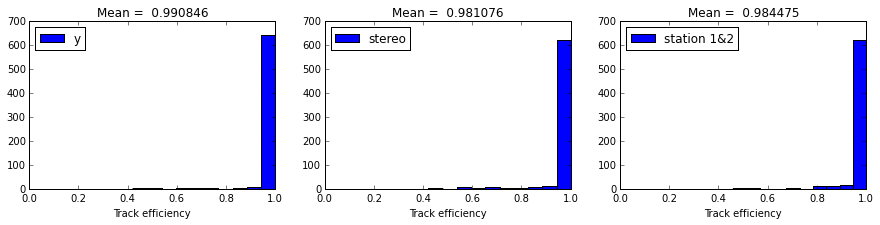

In [25]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

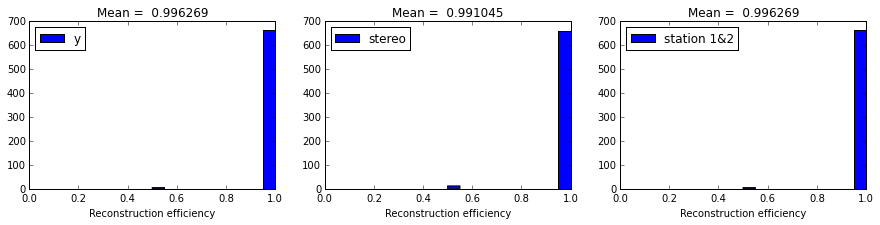

In [26]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [27]:
tracks_metrics_after_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.993260
RecoEff         0.994776
GhostRate       0.052985
CloneRate       0.001493
dtype: float64

### Stereo-views

In [28]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.987770
RecoEff         0.985821
GhostRate       0.040299
CloneRate       0.000746
dtype: float64

### Station 3&4

In [29]:
tracks_metrics_after_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.989810
RecoEff         0.991045
GhostRate       0.052985
CloneRate       0.000000
dtype: float64

### Tracks efficiency

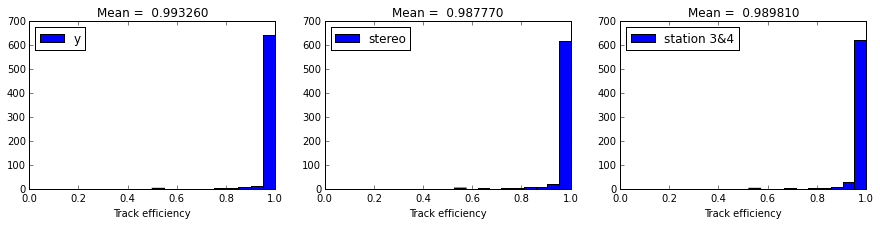

In [30]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

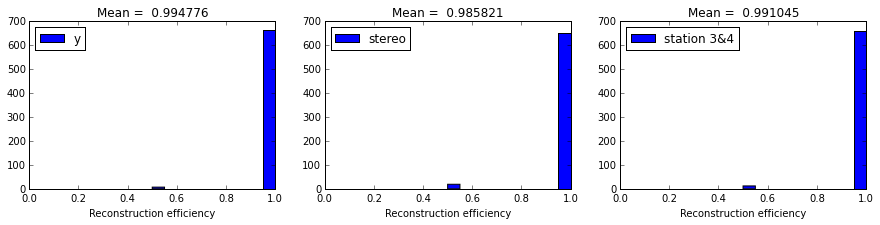

In [31]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [32]:
combinations_quality.mean(axis=0)

EventID      2555.164179
RecoEff         0.961194
GhostRate       0.002985
CloneRate       0.000000
NCombined       1.922388
dtype: float64

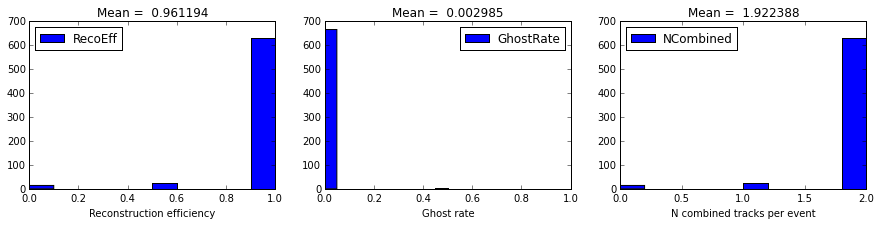

In [33]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

94.1791044776


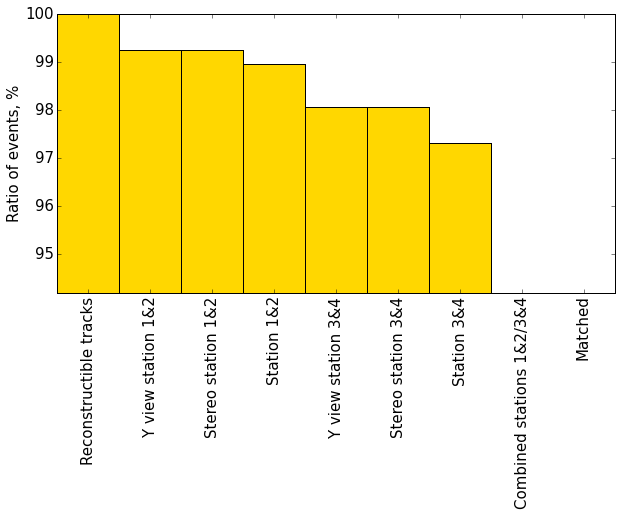

In [34]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages[pass_stages.columns[1:]].sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(10,5))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, size=15)
plt.yticks(size=15)
plt.xlim(-0.5, 8.5)
plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=15)
plt.show()

In [35]:
bar_values

array([ 100.        ,   99.25373134,   99.25373134,   98.95522388,
         98.05970149,   98.05970149,   97.31343284,   94.17910448,
         94.17910448])

# Momentum

In [36]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

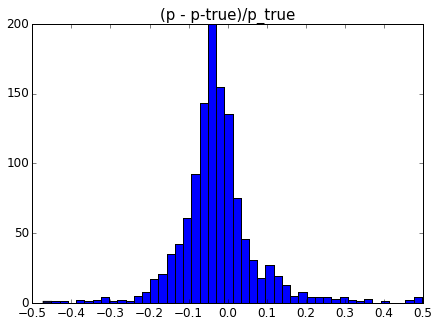

In [37]:
plt.figure(figsize=(7, 5))
plt.hist(p_err[numpy.isfinite(p_err)], bins=1000)

plt.title('(p - p-true)/p_true', size=15)
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.5, 0.5)
plt.show()

In [38]:
len(p_err) - len(p_err[numpy.isfinite(p_err)])

4

# Did not recognized tracks

In [39]:
pass_stages[pass_stages.Matching.values == 0]

,EventID,RecoEvents,Y12,Stereo12,Stations12,Y34,Stereo34,Stations34,Combination,Matching
9,3085,1,1,1,1,1,1,1,0,0
42,1090,1,1,1,1,1,1,1,0,0
54,85,1,1,1,1,1,1,1,0,0
61,3165,1,1,1,1,1,1,1,0,0
78,1142,1,1,1,1,1,1,1,0,0
95,143,1,1,1,1,1,1,0,0,0
119,3253,1,0,0,0,0,0,0,0,0
154,4747,1,1,1,1,1,1,1,0,0
155,2277,1,0,0,0,0,0,0,0,0
157,4817,1,1,1,1,1,1,1,0,0


In [40]:
bad_events = pass_stages[pass_stages.Matching.values == 0]['EventID'].values

3085.0


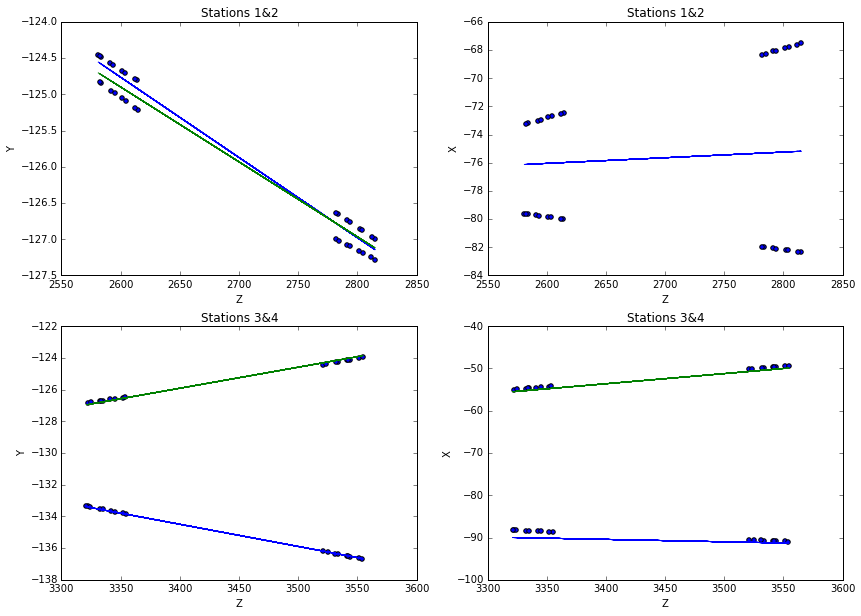

1090.0


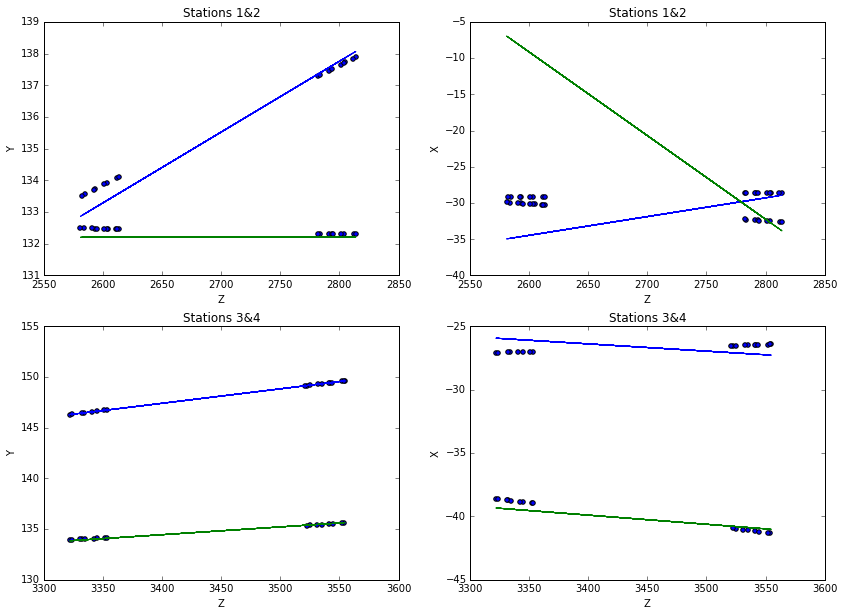

85.0


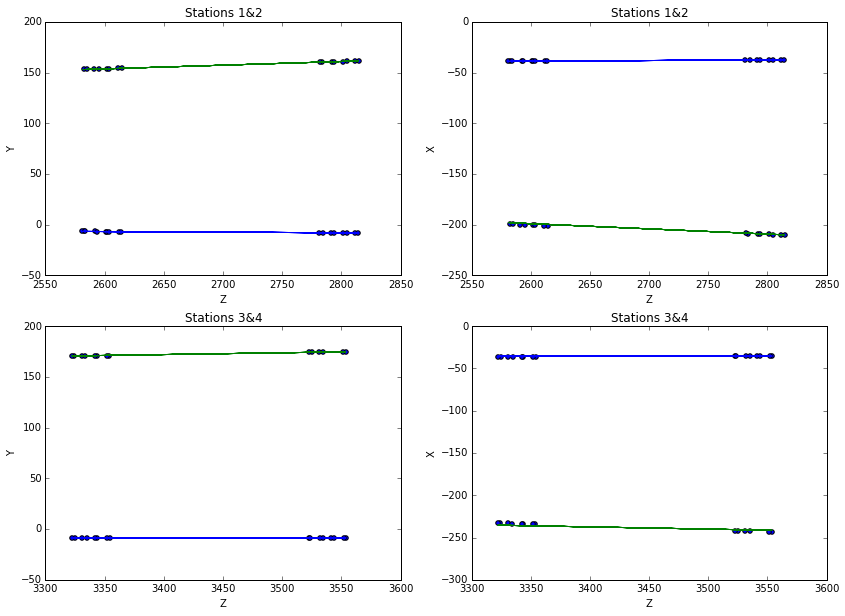

3165.0


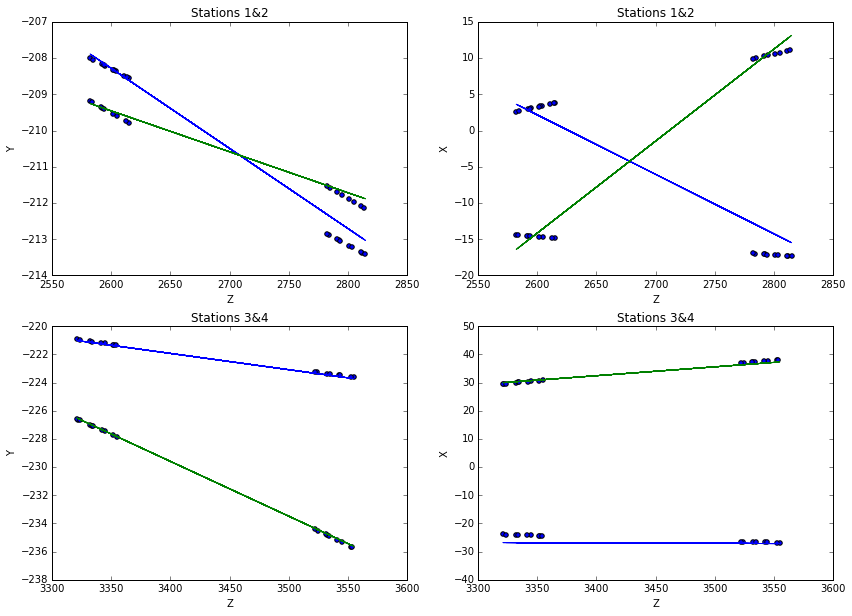

1142.0


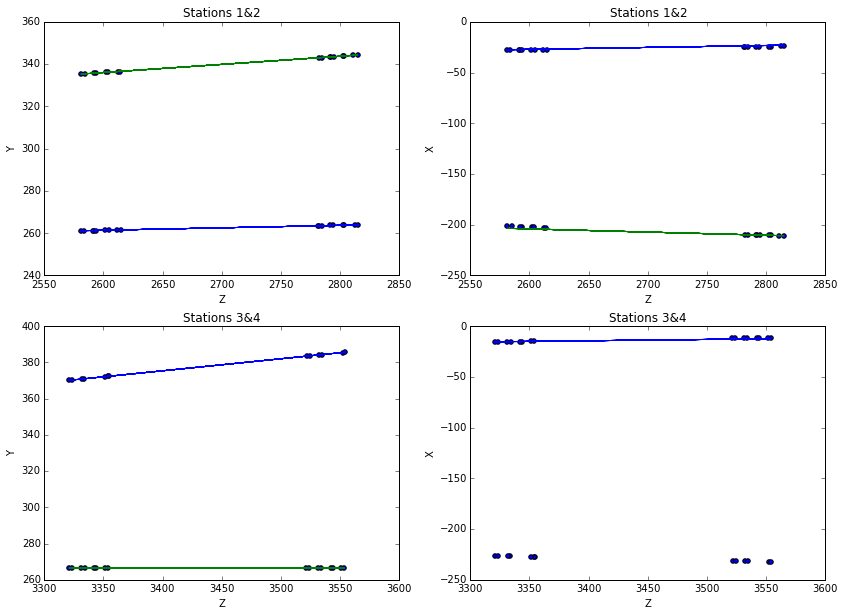

143.0


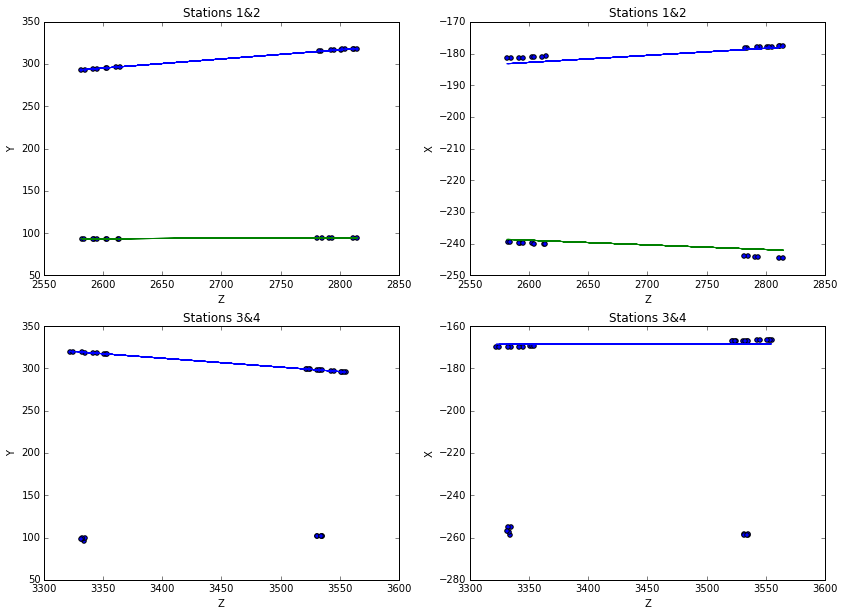

3253.0


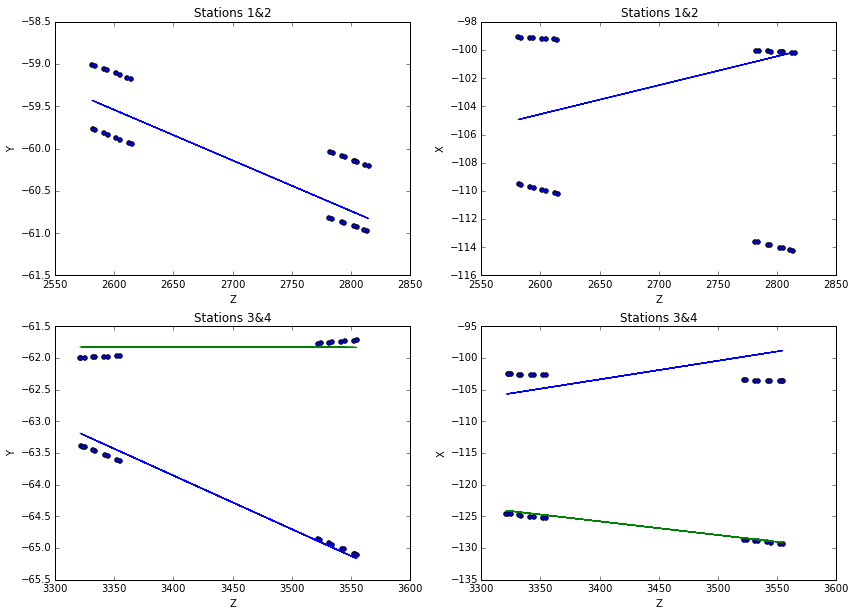

4747.0


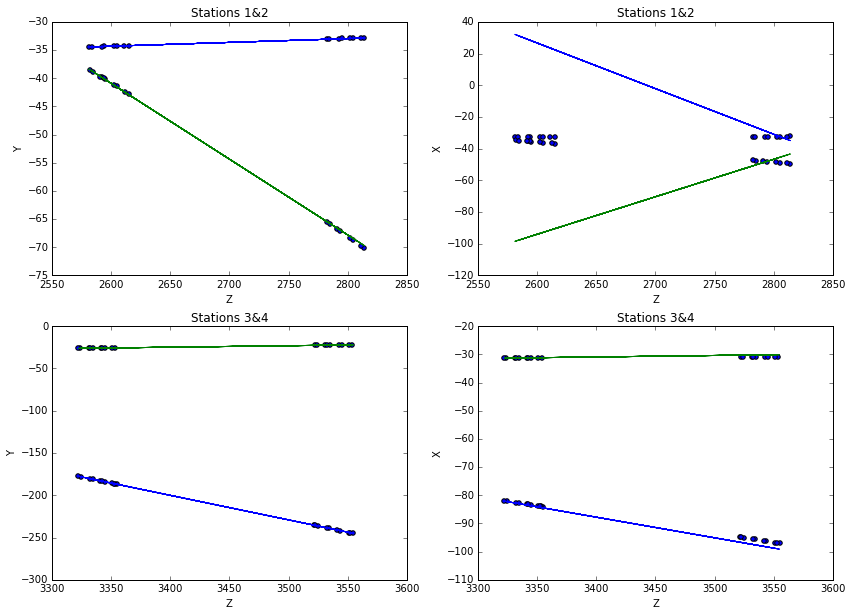

2277.0


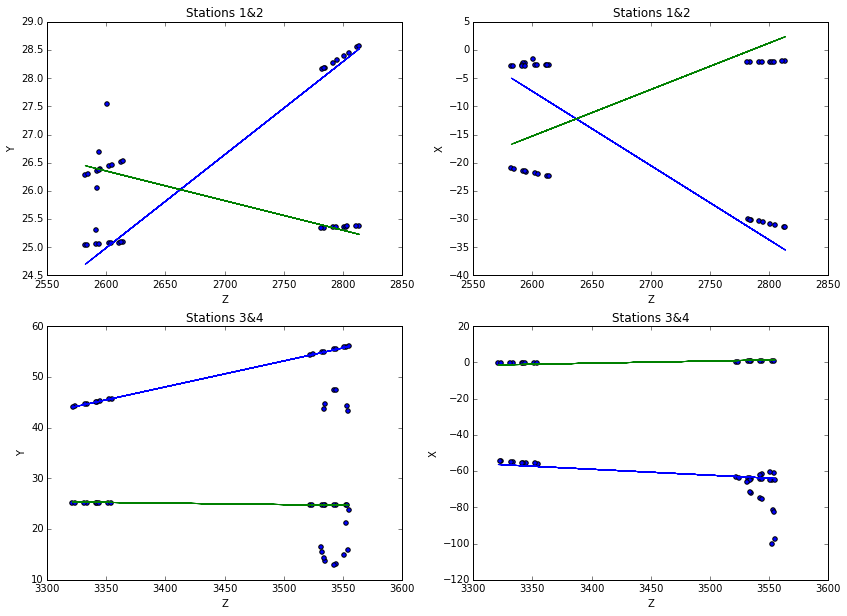

4817.0


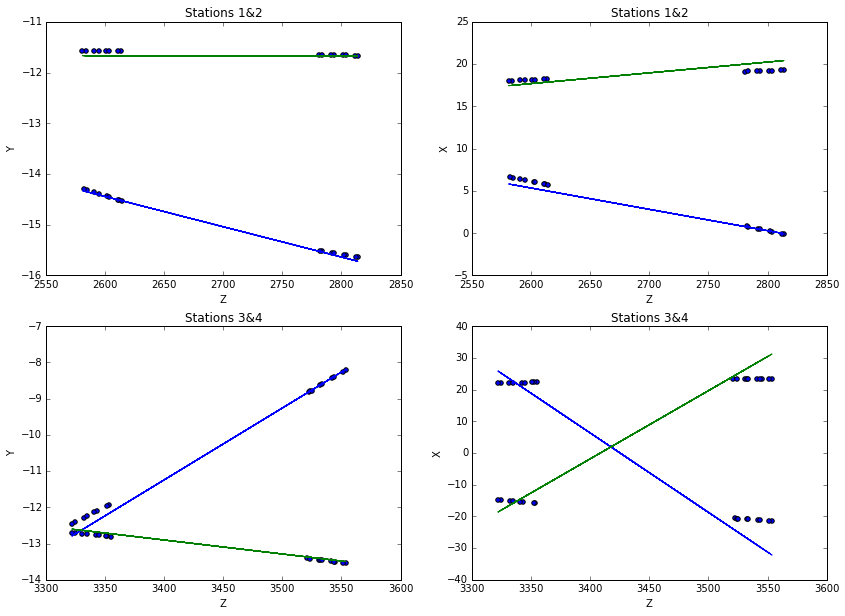

1262.0


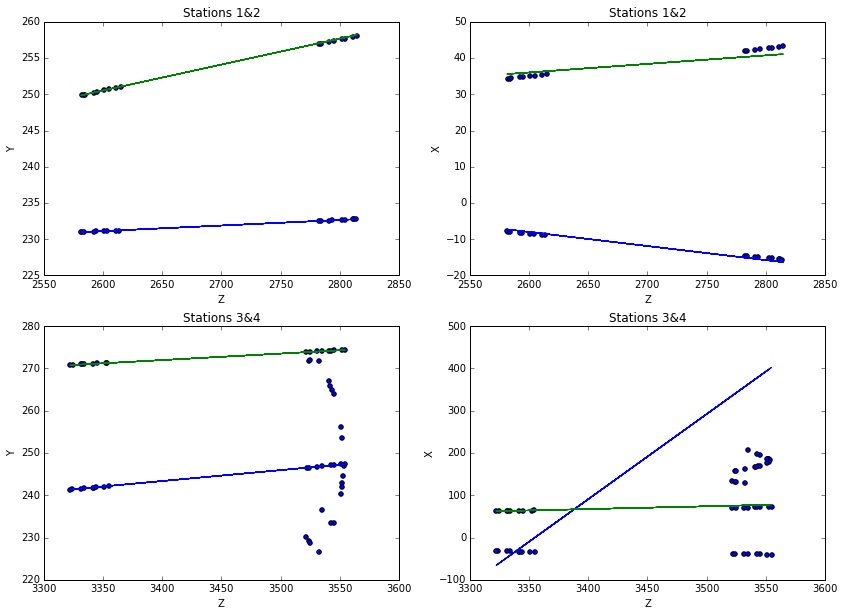

4342.0


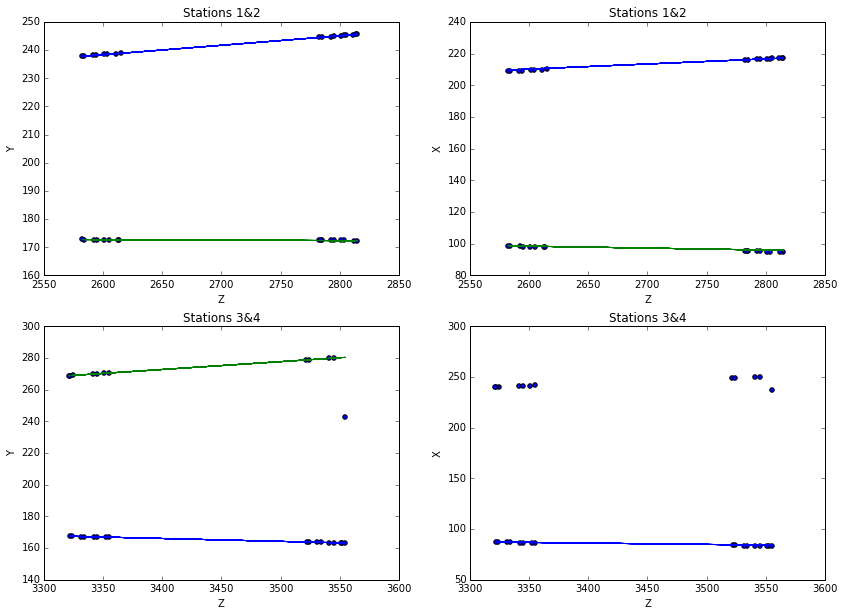

2295.0


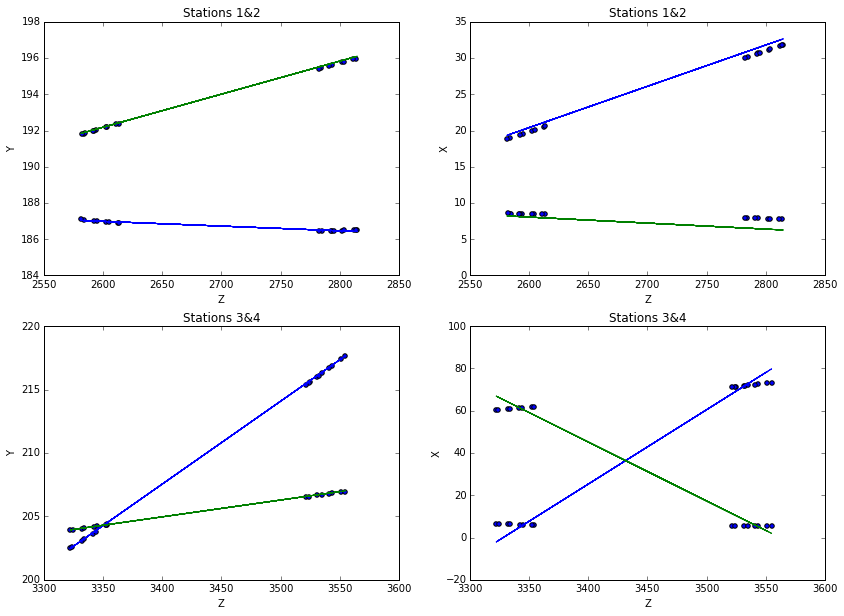

270.0


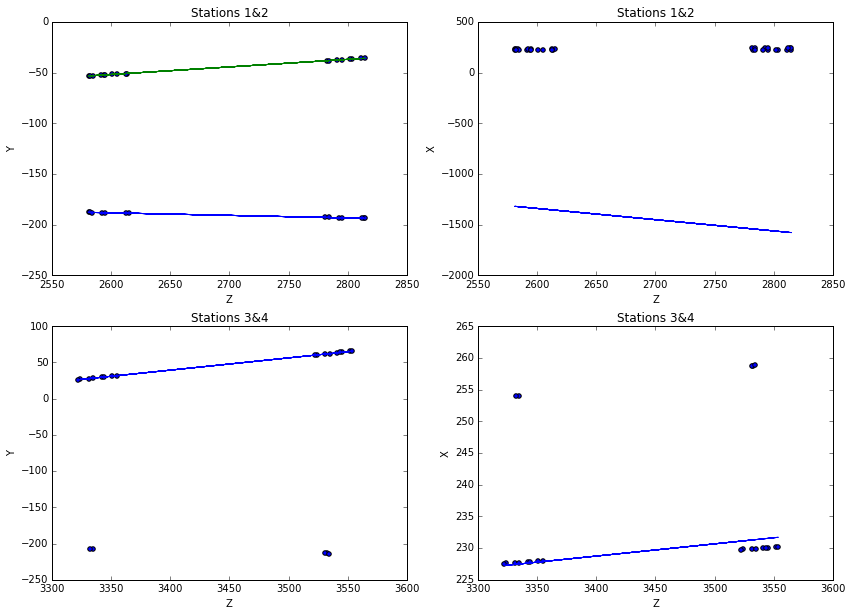

4428.0


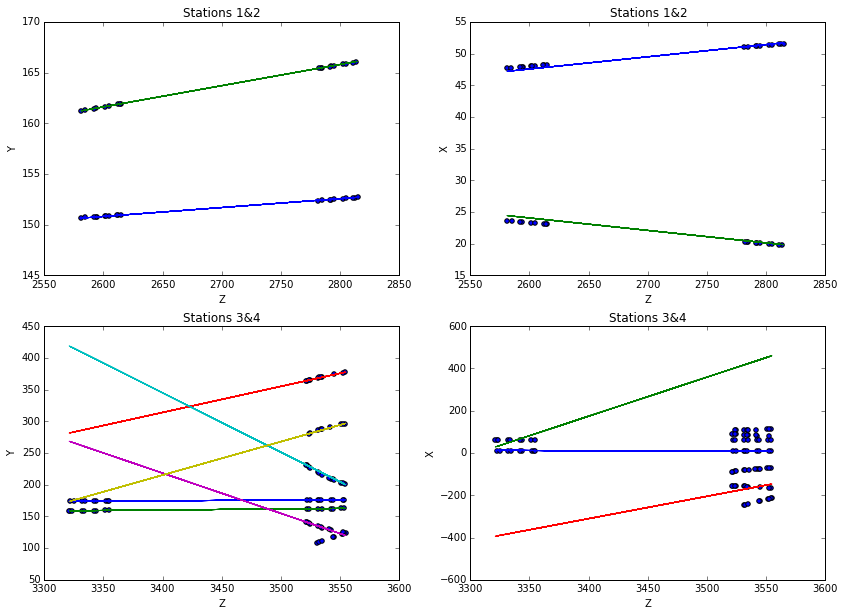

3781.0


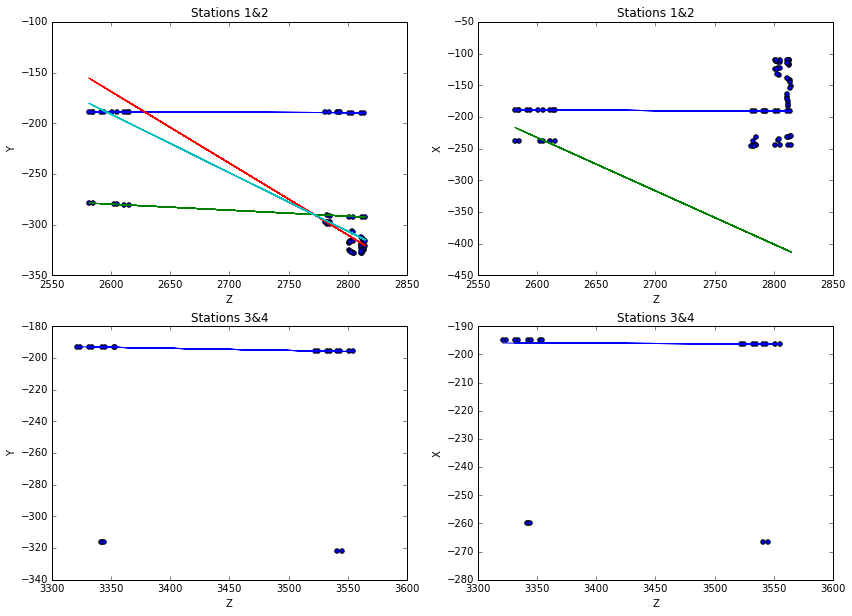

4490.0


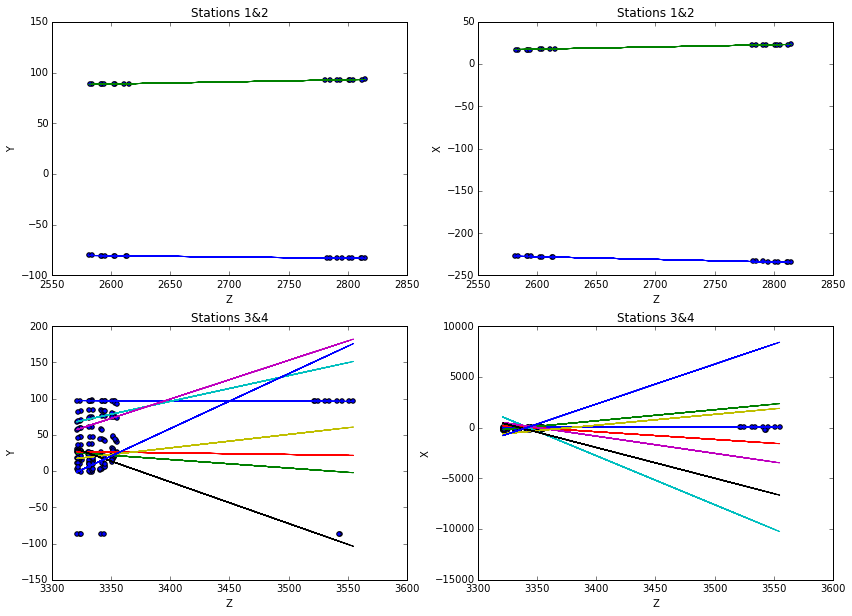

2455.0


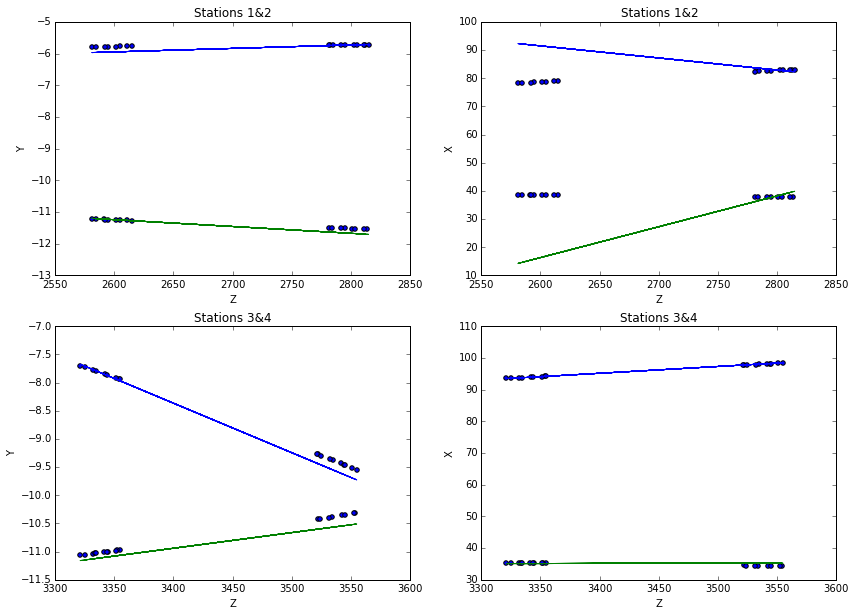

426.0


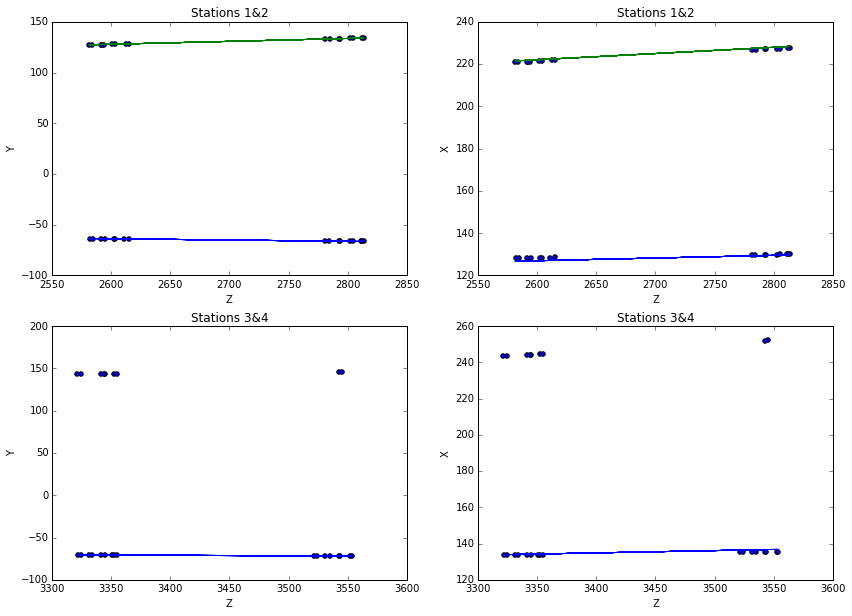

4124.0


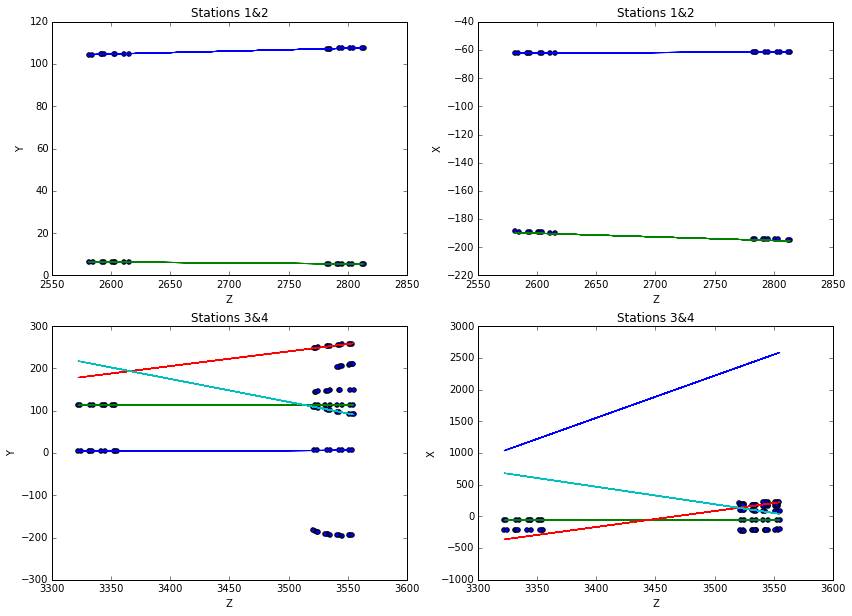

4175.0


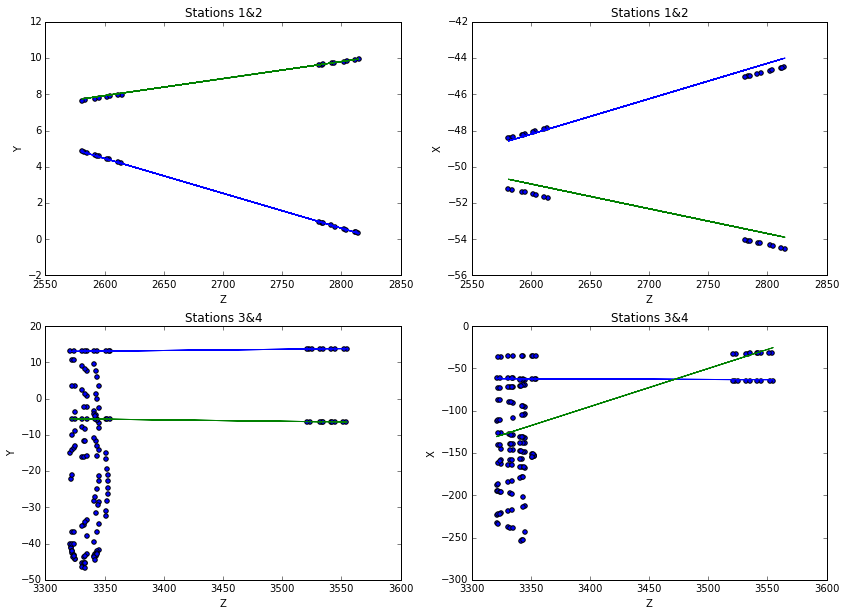

1528.0


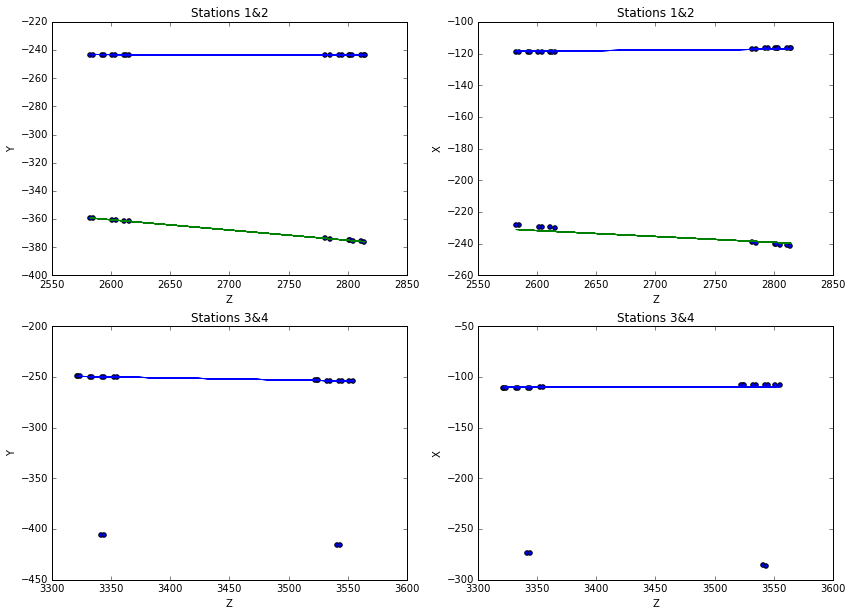

1533.0


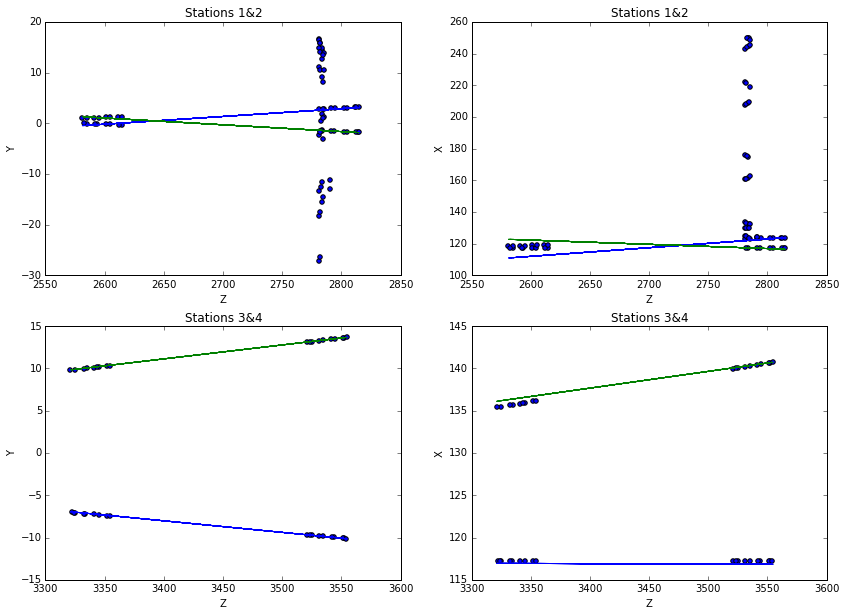

2605.0


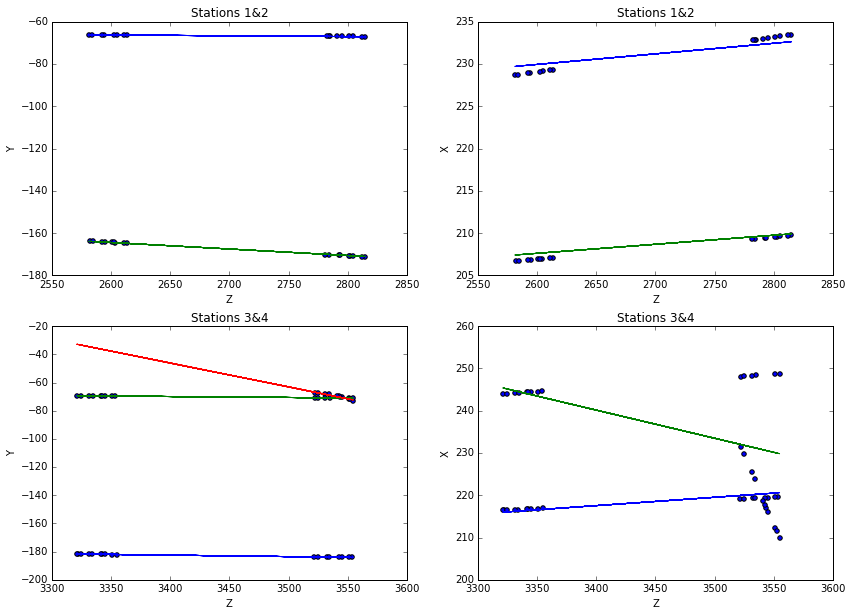

3670.0


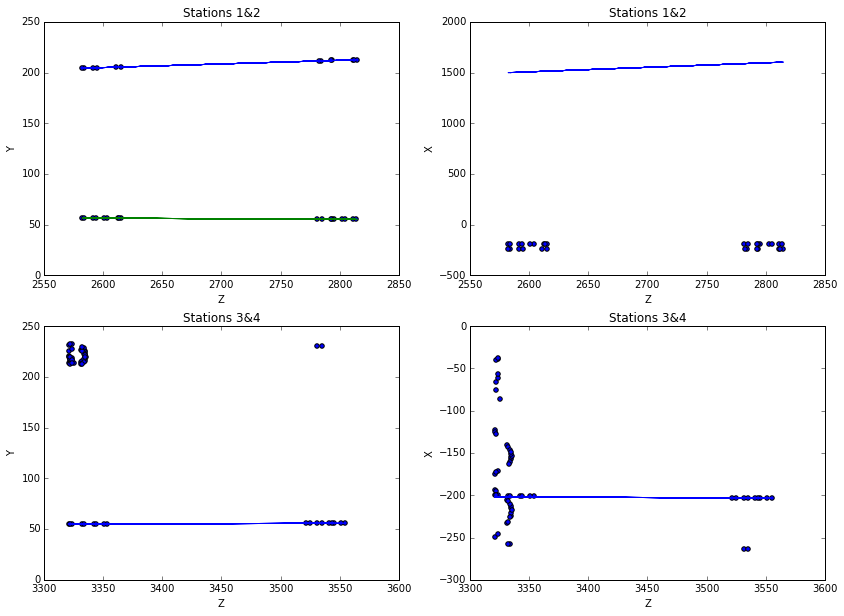

3498.0


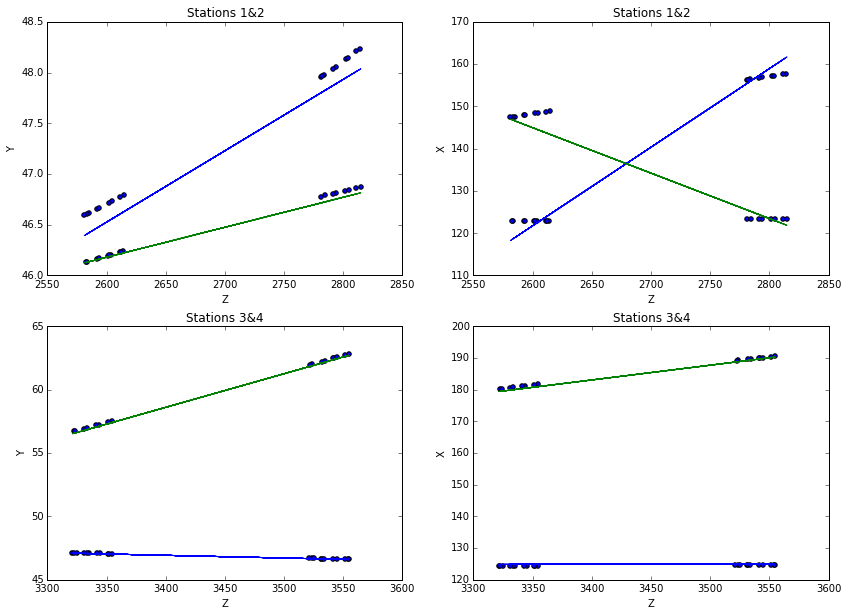

793.0


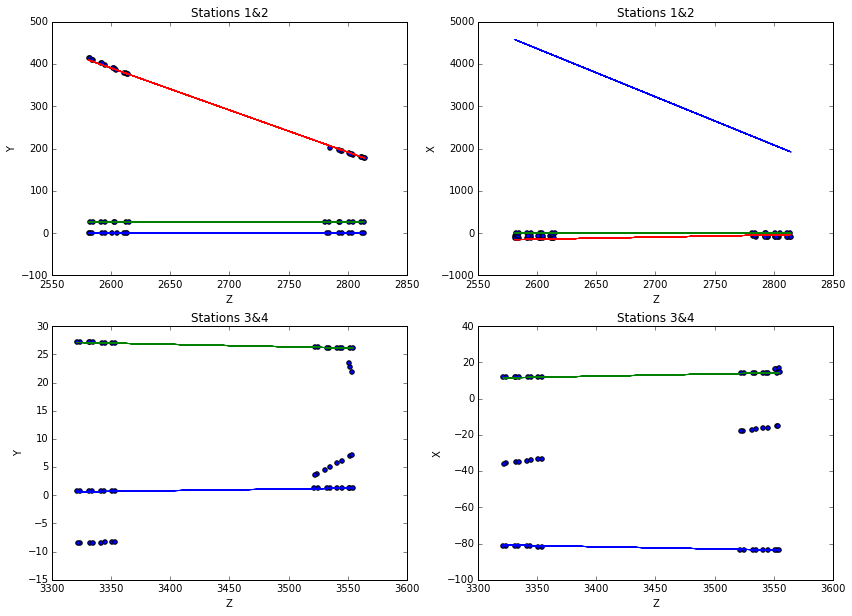

670.0


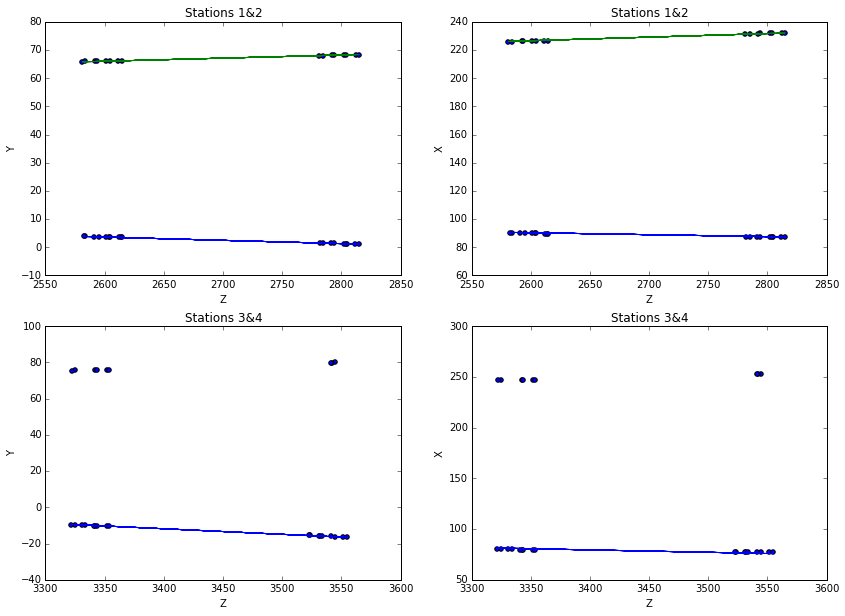

3749.0


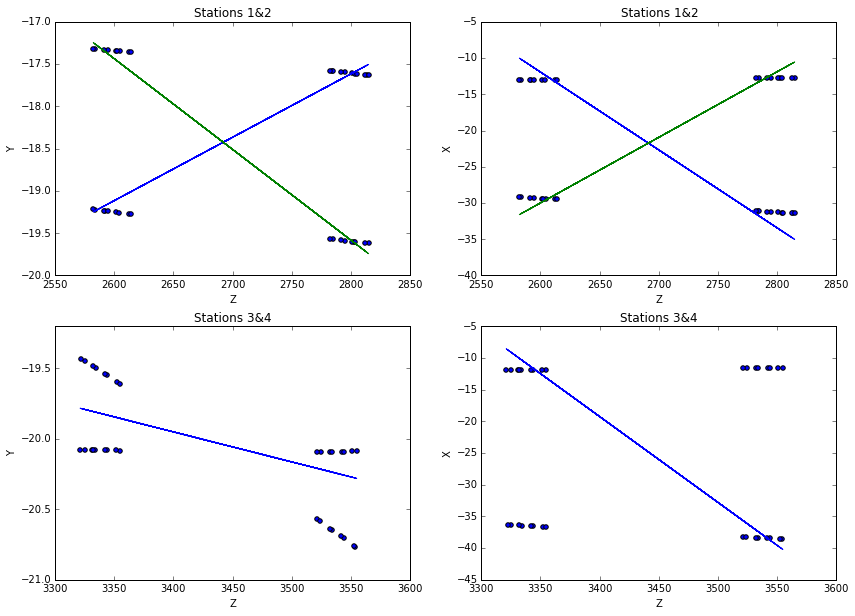

1722.0


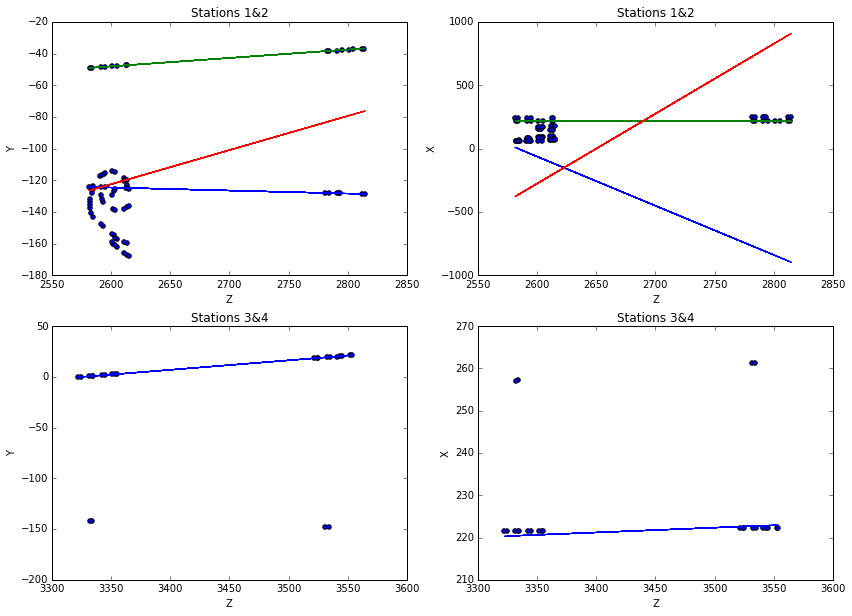

2762.0


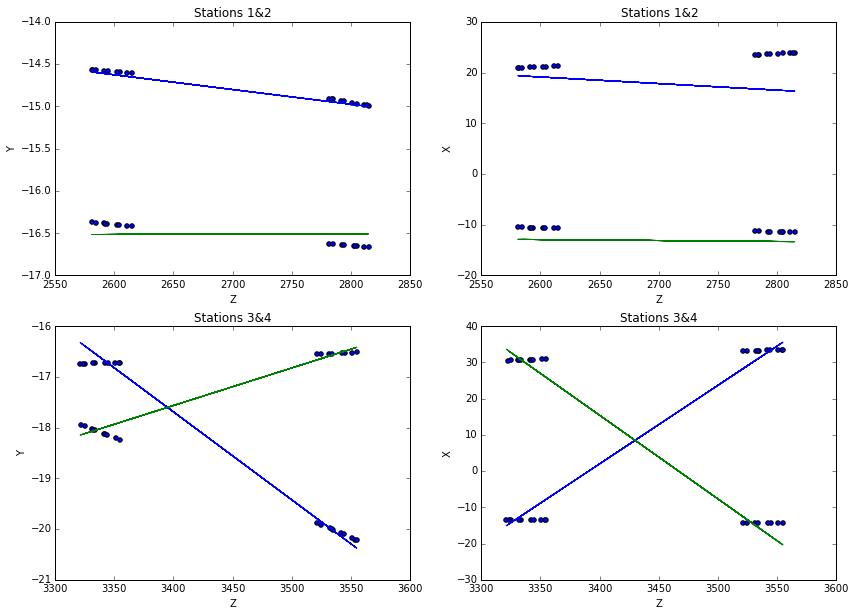

715.0


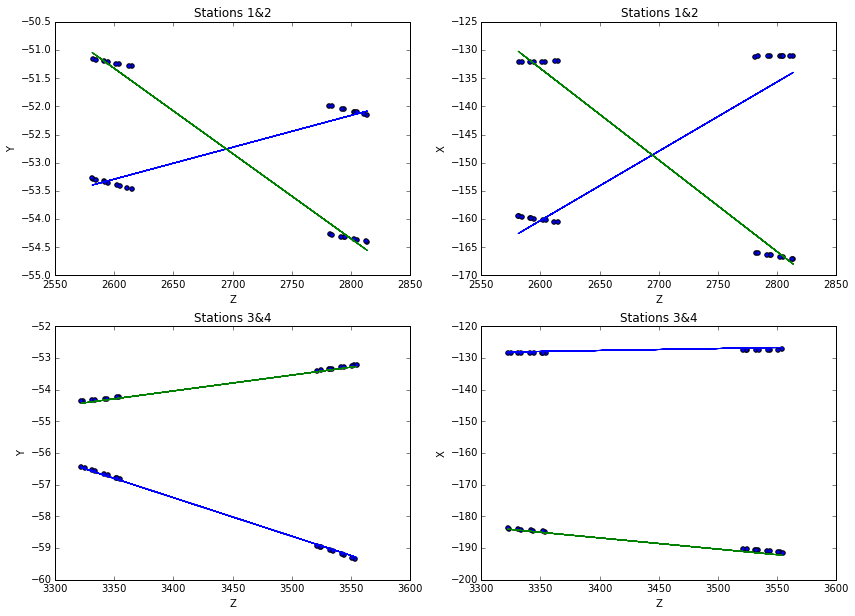

1756.0


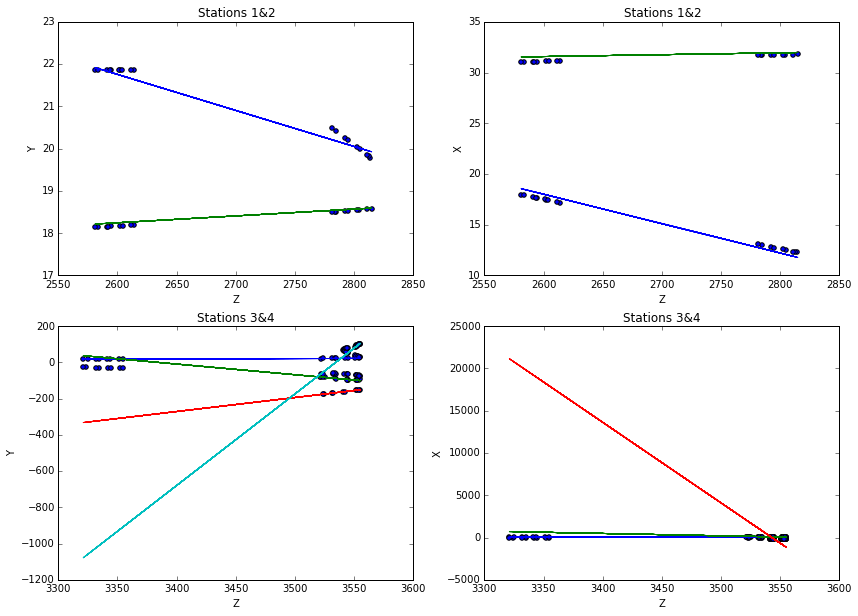

1769.0


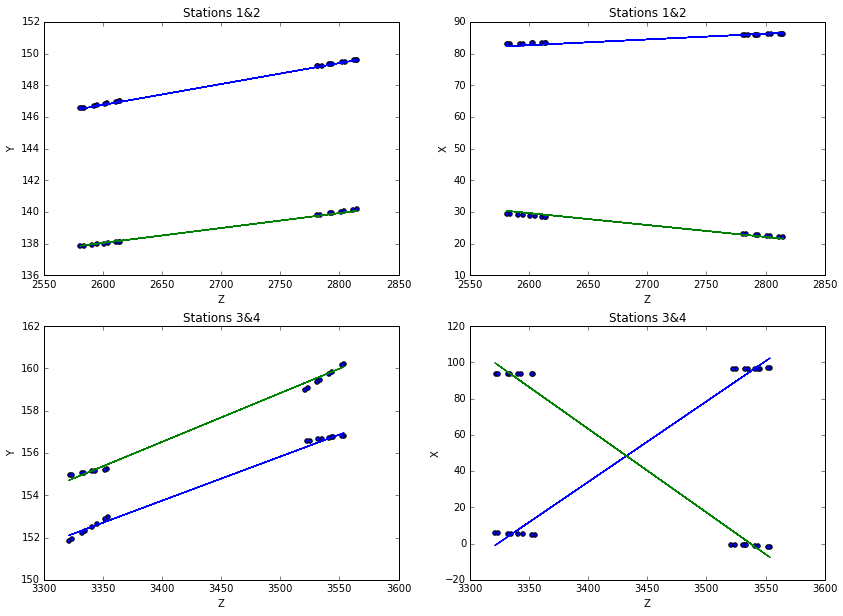

916.0


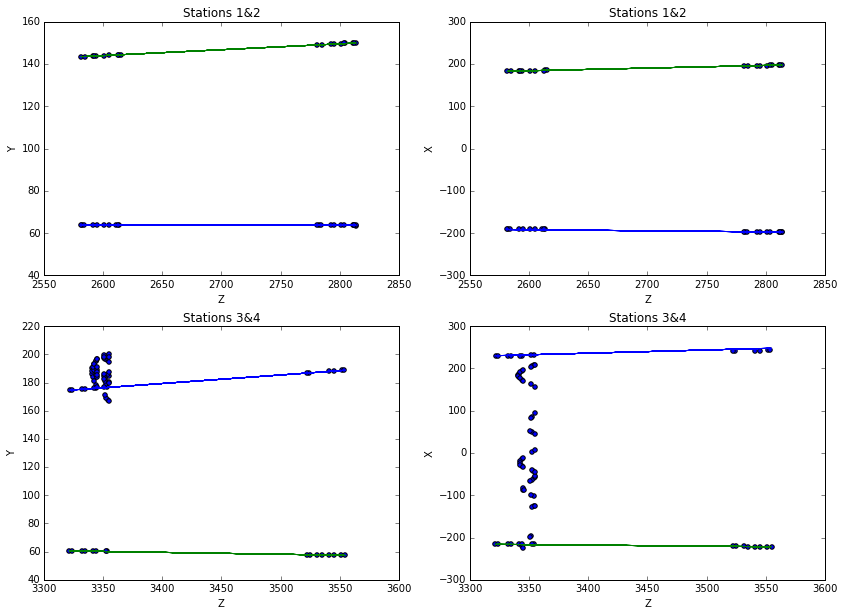

970.0


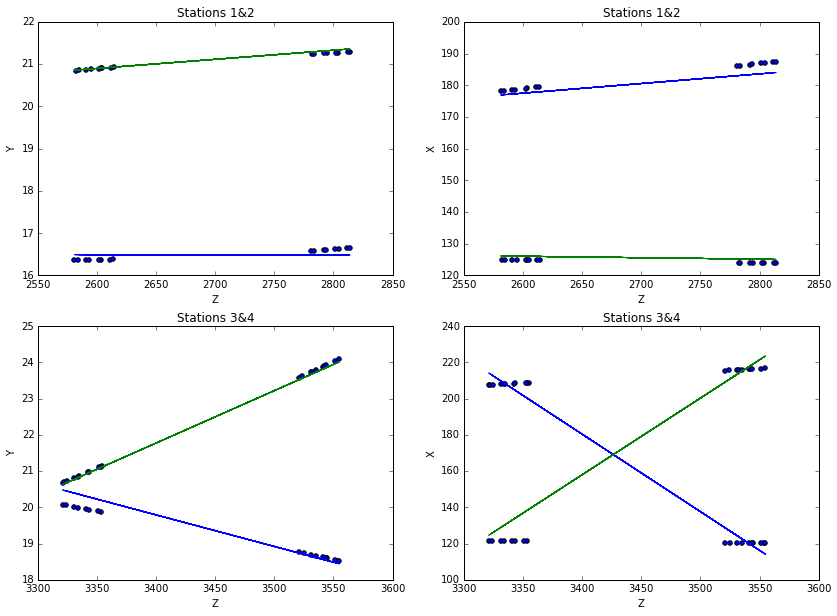

4600.0


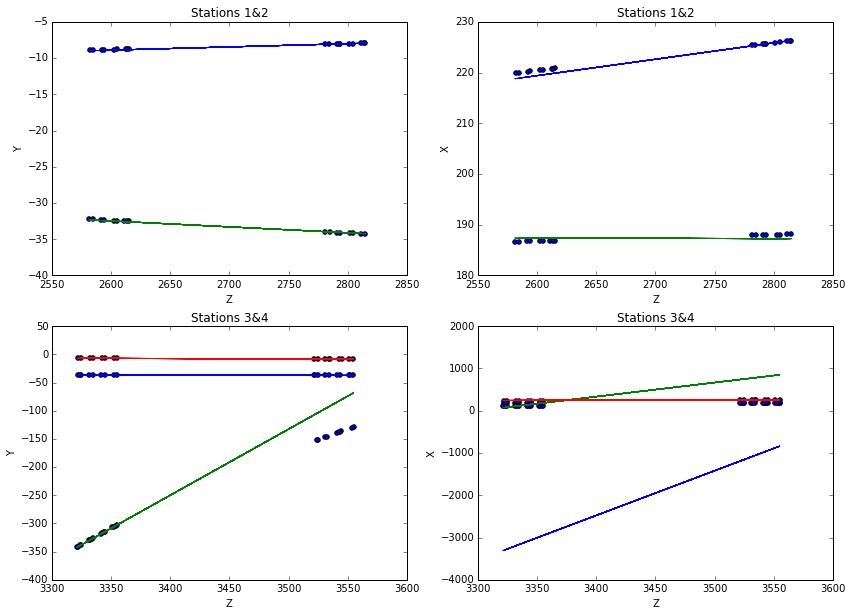

2040.0


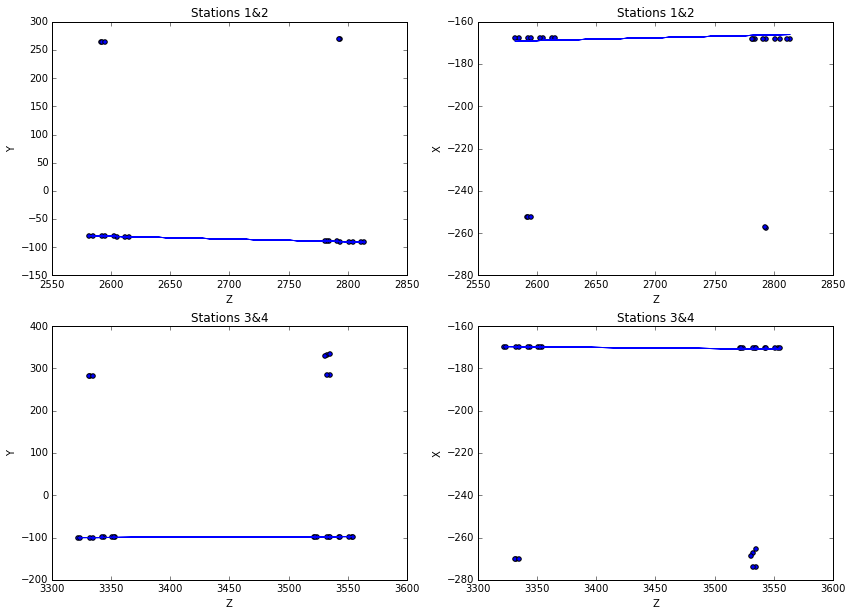

1023.0


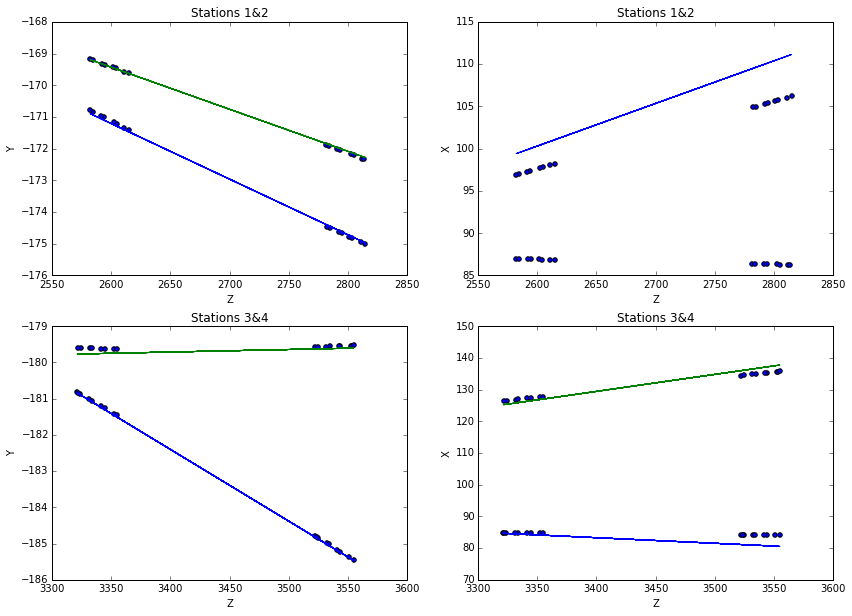

In [41]:
from utils import plot_event

for event_id in bad_events:
    print event_id
    plot_event(event_id, data, tracks)